In [1]:
import pandas as pd
import numpy as np


In [2]:
preprocessed_df = pd.read_csv('preprocessed_data.csv')

In [3]:
nps_preprocessed_df = pd.read_excel('NPS_stocks.xlsx')
nps_preprocessed_df.head()

preprocessed_df = pd.read_csv('preprocessed_data.csv')
preprocessed_df.head()

media_data = pd.read_excel('media_data.xlsx')
media_data.head()

preprocessed_df = preprocessed_df.drop('gmv_category', axis=1)

preprocessed_df['is_weekend'] = preprocessed_df['is_weekend'].astype(int)
preprocessed_df['is_special_date'] = preprocessed_df['is_special_date'].astype(int)

preprocessed_df = preprocessed_df.rename(columns={'sales_mark': 'is_sale'})

# Revenue and Sales KPIs
total_gmv = preprocessed_df['gmv'].sum()
total_units = preprocessed_df['units'].sum()
total_orders = preprocessed_df['order_id'].nunique()
average_order_value = total_gmv / total_orders

# Customer and Engagement KPIs
first_orders = preprocessed_df[preprocessed_df['first_order_flag'] == 1].shape[0]
repeat_orders = total_orders - first_orders
first_order_rate = first_orders / total_orders
repeat_order_rate = repeat_orders / total_orders

# Operational and Fulfillment KPIs
delivery_timeliness = (preprocessed_df['deliverybdays'] <= preprocessed_df['sla']).mean() * 100
order_fulfillment_efficiency = (preprocessed_df['deliverybdays'] - preprocessed_df['sla']).mean()

# Seasonal and Promotional Impact
weekend_sales = preprocessed_df[preprocessed_df['is_weekend'] == 1]['gmv'].sum()
special_date_sales = preprocessed_df[preprocessed_df['is_special_date'] == 1]['gmv'].sum()

# Discount and Sales Strategy
if 'is_sale' in preprocessed_df.columns:
    discount_rate = preprocessed_df[preprocessed_df['is_sale'] == 1].shape[0] / total_orders
else:
    discount_rate = "Not Applicable"

# Display KPIs
print(f"Total GMV: {total_gmv}")
print(f"Total Units Sold: {total_units}")
print(f"Average Order Value: {average_order_value}")
print(f"First Order Rate: {first_order_rate}")
print(f"Repeat Order Rate: {repeat_order_rate}")
print(f"Delivery Timeliness: {delivery_timeliness}%")
print(f"Order Fulfillment Efficiency: {order_fulfillment_efficiency} days")
print(f"Weekend Sales: {weekend_sales}")
print(f"Special Date Sales: {special_date_sales}")
print(f"Discount Rate: {discount_rate}")

# Load external NPS data from Excel
# nps_preprocessed_df = pd.read_excel('NPS_stocks.xlsx', sheet_name='Sheet1')
nps_preprocessed_df['order_month'] = pd.to_datetime(nps_preprocessed_df[['Year', 'Month']].assign(day=1)).dt.to_period('M')
nps_preprocessed_df = nps_preprocessed_df[['order_month', 'NPS']]

# Convert date columns to datetime and create period columns
preprocessed_df['order_date'] = pd.to_datetime(preprocessed_df['order_date'])
preprocessed_df['order_month'] = preprocessed_df['order_date'].dt.to_period('M')
preprocessed_df['order_week'] = preprocessed_df['order_date'].dt.to_period('W')

# Flag repeat customers
customer_order_counts = preprocessed_df.groupby('cust_id')['order_id'].nunique()
repeat_customers = customer_order_counts[customer_order_counts > 1].index
preprocessed_df['is_repeat_customer'] = preprocessed_df['cust_id'].isin(repeat_customers)

# Monthly KPIs aggregation
monthly_kpis = preprocessed_df.groupby('order_month').agg(
    total_gmv=('gmv', 'sum'),
    total_units=('units', 'sum'),
    total_orders=('order_id', 'nunique'),
    first_orders=('first_order_flag', 'sum'),
    weekend_sales=('gmv', lambda x: x[preprocessed_df.loc[x.index, 'is_weekend'] == 1].sum()),
    discount_rate=('is_sale', 'mean'),
    total_unique_customers=('cust_id', 'nunique')
).reset_index()

# Trim the first 2 rows and the last row
monthly_kpis = monthly_kpis.iloc[2:-1].reset_index(drop=True)

# Additional metrics calculation
monthly_kpis['average_order_value'] = monthly_kpis['total_gmv'] / monthly_kpis['total_orders']
monthly_kpis['repeat_orders'] = monthly_kpis['total_orders'] - monthly_kpis['first_orders']
monthly_kpis['repeat_customers'] = monthly_kpis['total_unique_customers'] - monthly_kpis['first_orders']
monthly_kpis['first_order_rate'] = monthly_kpis['first_orders'] / monthly_kpis['total_orders']
monthly_kpis['repeat_order_rate'] = monthly_kpis['repeat_orders'] / monthly_kpis['total_orders']
monthly_kpis['customer_retention_rate'] = monthly_kpis['repeat_customers'] / monthly_kpis['total_unique_customers'] * 100

# Churn Calculation function (1-month lookback)
def calculate_churn(current_month, months_lookback=1):
    current_month_start = current_month.to_timestamp(how='start')
    lookback_start = (current_month - months_lookback).to_timestamp(how='start')

    customers_in_lookback = preprocessed_df[(preprocessed_df['order_date'] >= lookback_start) &
                               (preprocessed_df['order_date'] < current_month_start)]['cust_id'].unique()
    customers_in_current = preprocessed_df[preprocessed_df['order_month'] == current_month]['cust_id'].unique()

    churned_customers = np.setdiff1d(customers_in_lookback, customers_in_current)
    churn_rate = len(churned_customers) / len(customers_in_lookback) * 100 if len(customers_in_lookback) > 0 else np.nan
    return churn_rate

# Apply churn calculation
X_months = 1
churn_rates = []
months_sorted = sorted(monthly_kpis['order_month'])
for idx, month in enumerate(months_sorted):
    if idx >= X_months:
        churn_rates.append({'order_month': month, 'churn_rate': calculate_churn(month, X_months)})
churn_preprocessed_df = pd.DataFrame(churn_rates)
monthly_kpis = pd.merge(monthly_kpis, churn_preprocessed_df, on='order_month', how='left')

# Merge NPS scores from external data
monthly_kpis = pd.merge(monthly_kpis, nps_preprocessed_df, on='order_month', how='left')

# Warehouse efficiency calculation (ensure columns exist)
if {'deliverybdays', 'deliverycdays'}.issubset(preprocessed_df.columns):
    preprocessed_df['delivery_days'] = preprocessed_df['deliverybdays'] + preprocessed_df['deliverycdays']
    warehouse_metrics = preprocessed_df.groupby('order_month')['delivery_days'].mean().reset_index(name='logistics_inefficiency')
    monthly_kpis = pd.merge(monthly_kpis, warehouse_metrics, on='order_month', how='left')
else:
    monthly_kpis['logistics_inefficiency'] = np.nan

# Risk thresholds definition
risk_thresholds = {
    'high_churn_risk': 95,
    'low_nps_risk': 51,
    'delivery_risk': 1
}

# Calculate risk indicators
monthly_kpis['high_churn_risk'] = (monthly_kpis['churn_rate'] > risk_thresholds['high_churn_risk']).astype(int)
monthly_kpis['low_nps_risk'] = (monthly_kpis['NPS'] < risk_thresholds['low_nps_risk']).astype(int)
monthly_kpis['delivery_risk'] = (monthly_kpis['logistics_inefficiency'] > risk_thresholds['delivery_risk']).astype(int)

risk_columns = ['high_churn_risk', 'low_nps_risk', 'delivery_risk']
monthly_kpis[risk_columns] = monthly_kpis[risk_columns].fillna(0)
monthly_kpis['risk_score'] = monthly_kpis[risk_columns].sum(axis=1)

# Revenue growth metrics calculation
monthly_kpis.sort_values('order_month', inplace=True)
monthly_kpis['gmv_growth_pct'] = monthly_kpis['total_gmv'].pct_change() * 100
monthly_kpis['aov_growth_pct'] = monthly_kpis['average_order_value'].pct_change() * 100

# KPI Summary Function for latest month
def create_latest_summary(kpi_preprocessed_df):
    latest_data = kpi_preprocessed_df.iloc[-1]
    prev_data_available = len(kpi_preprocessed_df) >= 2

    summary_dict = {
        "Month": str(latest_data["order_month"]),
        "Revenue": {
            "Total GMV": f"${latest_data.total_gmv:,.2f}",
            "GMV Growth": f"{latest_data.gmv_growth_pct:.1f}%" if prev_data_available else "N/A",
            "AOV": f"${latest_data.average_order_value:.2f}",
            "AOV Growth": f"{latest_data.aov_growth_pct:.1f}%" if prev_data_available else "N/A"
        },
        "Customer Metrics": {
            "Retention Rate": f"{latest_data.customer_retention_rate:.1f}%",
            "Churn Rate": f"{latest_data.churn_rate:.1f}%" if not np.isnan(latest_data.churn_rate) else "N/A",
            "NPS Score": f"{latest_data.NPS:.1f}" if not np.isnan(latest_data.NPS) else "N/A"
        },
        "Risk Indicators Active": int(latest_data.risk_score)
    }
    return summary_dict

latest_summary_report = create_latest_summary(monthly_kpis)

# Display KPI dashboard summary clearly formatted
print("\n=== ElectroMart E-commerce KPI Dashboard ===\n")
print(f"Latest Month: {latest_summary_report.pop('Month')}\n")
for section, metrics in latest_summary_report.items():
    print(f"{section}:")
    if isinstance(metrics, dict):
        for metric_name, value in metrics.items():
            print(f"  - {metric_name}: {value}")
    else:
        print(f"  - {metrics}")
# Display the trimmed DataFrame
monthly_kpis

# Assuming 'monthly_kpis' is your DataFrame
# Fill NaN values with the average of the next 3 values

def fill_nan_with_next_3_avg(preprocessed_df):
  for col in preprocessed_df.columns:
    if preprocessed_df[col].isnull().any():
      for i in range(len(preprocessed_df)):
        if pd.isnull(preprocessed_df.loc[i, col]):
          next_3_values = preprocessed_df.loc[i+1:min(i+3, len(preprocessed_df)-1), col].dropna().values
          if len(next_3_values) > 0:
            preprocessed_df.loc[i, col] = np.mean(next_3_values)
  return preprocessed_df


monthly_kpis = fill_nan_with_next_3_avg(monthly_kpis)

# Assuming 'monthly_kpis' is your DataFrame
# if 'order_month' in monthly_kpis.columns:
#   monthly_kpis = monthly_kpis.drop('order_month', axis=1)

monthly_kpis.info()

revenue = pd.DataFrame({'revenue': monthly_kpis['total_gmv']})

# # Assuming 'monthly_kpis' is your DataFrame
# columns_to_drop = ['high_churn_risk', 'low_nps_risk','delivery_risk','risk_score']
# for column in columns_to_drop:  # Iterate through each column name
#   if column in monthly_kpis.columns:  # Check if the column exists
#     monthly_kpis = monthly_kpis.drop(column, axis=1)  # Drop the column

# Assuming 'monthly_kpis' is your DataFrame
for column in monthly_kpis.columns:
  if pd.api.types.is_numeric_dtype(monthly_kpis[column]):
    # Perform Min-Max normalization
    monthly_kpis[column] = (monthly_kpis[column] - monthly_kpis[column].min()) / (monthly_kpis[column].max() - monthly_kpis[column].min())

# Print the normalized DataFrame
monthly_kpis.head()

Total GMV: 4045890692
Total Units Sold: 1685242
Average Order Value: 2695.145670363988
First Order Rate: 0.8426787780521551
Repeat Order Rate: 0.15732122194784492
Delivery Timeliness: 95.56489958904044%
Order Fulfillment Efficiency: -4.755869031503666 days
Weekend Sales: 1255236102
Special Date Sales: 0
Discount Rate: 0.14796189922973774

=== ElectroMart E-commerce KPI Dashboard ===

Latest Month: 2024-06

Revenue:
  - Total GMV: $305,913,306.00
  - GMV Growth: -25.3%
  - AOV: $2571.74
  - AOV Growth: -3.7%
Customer Metrics:
  - Retention Rate: 7.7%
  - Churn Rate: 95.3%
  - NPS Score: 50.5
Risk Indicators Active:
  - 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype    
---  ------                   --------------  -----    
 0   order_month              12 non-null     period[M]
 1   total_gmv                12 non-null     int64    
 2   total_units              12 non-null    

,order_month,total_gmv,total_units,total_orders,first_orders,weekend_sales,discount_rate,total_unique_customers,average_order_value,repeat_orders,...,customer_retention_rate,churn_rate,NPS,logistics_inefficiency,high_churn_risk,low_nps_risk,delivery_risk,risk_score,gmv_growth_pct,aov_growth_pct
0,2023-07,0.345982,0.424188,0.432439,0.451332,0.357855,0.104915,0.431169,0.000000,0.282413,...,0.060604,0.442686,0.653846,0.000727,0.0,0.0,0.0,0.000000,0.333725,0.594188
1,2023-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.126146,0.000000,0.316495,0.000000,...,1.000000,1.000000,1.000000,0.005033,1.0,0.0,0.0,0.333333,0.000000,0.782564
2,2023-09,0.838811,1.000000,0.498112,0.520065,0.786426,0.000000,0.508905,1.000000,0.324270,...,0.138243,0.000000,0.160256,0.000143,0.0,1.0,0.0,0.333333,1.000000,1.000000
3,2023-10,1.000000,0.990320,1.000000,1.000000,0.738710,1.000000,1.000000,0.226060,0.889159,...,0.206397,0.328058,0.000000,0.000166,0.0,1.0,0.0,0.333333,0.001174,0.000000
4,2023-11,0.658895,0.622599,0.629082,0.593288,0.422727,0.895621,0.628267,0.279737,0.752780,...,0.381536,0.531137,0.166667,0.000000,1.0,1.0,0.0,0.666667,0.000648,0.469912


In [4]:
monthly_kpis

,order_month,total_gmv,total_units,total_orders,first_orders,weekend_sales,discount_rate,total_unique_customers,average_order_value,repeat_orders,...,customer_retention_rate,churn_rate,NPS,logistics_inefficiency,high_churn_risk,low_nps_risk,delivery_risk,risk_score,gmv_growth_pct,aov_growth_pct
0,2023-07,0.345982,0.424188,0.432439,0.451332,0.357855,0.104915,0.431169,0.000000,0.282413,...,0.060604,0.442686,0.653846,0.000727,0.0,0.0,0.0,0.000000,0.333725,0.594188
1,2023-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.126146,0.000000,0.316495,0.000000,...,1.000000,1.000000,1.000000,0.005033,1.0,0.0,0.0,0.333333,0.000000,0.782564
2,2023-09,0.838811,1.000000,0.498112,0.520065,0.786426,0.000000,0.508905,1.000000,0.324270,...,0.138243,0.000000,0.160256,0.000143,0.0,1.0,0.0,0.333333,1.000000,1.000000
3,2023-10,1.000000,0.990320,1.000000,1.000000,0.738710,1.000000,1.000000,0.226060,0.889159,...,0.206397,0.328058,0.000000,0.000166,0.0,1.0,0.0,0.333333,0.001174,0.000000
4,2023-11,0.658895,0.622599,0.629082,0.593288,0.422727,0.895621,0.628267,0.279737,0.752780,...,0.381536,0.531137,0.166667,0.000000,1.0,1.0,0.0,0.666667,0.000648,0.469912
5,2023-12,0.866801,0.761445,0.761419,0.802456,0.871565,0.553237,0.752902,0.382756,0.455262,...,0.000000,0.381712,0.089744,0.000335,0.0,1.0,0.0,0.333333,0.001295,0.510797
6,2024-01,0.769994,0.686015,0.694617,0.695293,0.893352,0.500691,0.693323,0.348921,0.613971,...,0.197773,0.416010,0.173077,0.003590,0.0,1.0,0.0,0.333333,0.000874,0.393596
7,2024-02,0.659254,0.686441,0.697710,0.677427,0.596618,0.277220,0.697168,0.163701,0.729982,...,0.295572,0.410441,0.378205,0.017111,0.0,1.0,0.0,0.333333,0.000842,0.267891
8,2024-03,0.803459,0.731062,0.735595,0.691697,0.859877,0.323980,0.730971,0.330519,0.891277,...,0.375305,0.353495,0.294872,0.070807,0.0,1.0,0.0,0.333333,0.001200,0.582328
9,2024-04,0.675452,0.638858,0.632027,0.578015,1.000000,0.000000,0.630361,0.303863,0.853842,...,0.467418,0.343559,0.474359,1.000000,0.0,0.0,1.0,0.333333,0.000827,0.398463


In [ ]:
order_data_with_weather = pd.read_csv("order_data_with_weather.csv")
order_data_with_weather.head()

order_data_with_weather.info()

# !pip install dcor

import dcor  # Install using: pip install dcor

# Load your dataset
df = order_data_with_weather.copy()

# Ensure 'stock_out' column exists
df["stock_out"] = (
    (df["deliverybdays"] + df["deliverycdays"] - df["product_procurement_sla"]>0)
).astype(int)

# Convert 'order_date' to numeric (days since first order)
df["order_date"] = pd.to_datetime(df["order_date"])
df["order_date_numeric"] = (df["order_date"] - df["order_date"].min()).dt.days  # Days since first order

# Encode 'fsn_id' as categorical numbers
df["fsn_id_numeric"] = df["fsn_id"].astype("category").cat.codes

# List of features to check distance correlation with 'stock_out'
features = ["Mean Temp (°C)", "Total Snow (cm)", "Total Rain (mm)", "pincode", "order_date_numeric", "fsn_id_numeric", "sla"]

# Compute distance correlation correctly
results = {}
for col in features:
    valid_rows = df[[col, "stock_out"]].dropna()  # Drop NaN values for computation
    results[col] = dcor.distance_correlation(valid_rows[col].values.astype(float), valid_rows["stock_out"].values.astype(float))

# Display results
print("Corrected Distance Correlation with Stock Out:")
for feature, corr in results.items():
    print(f"{feature}: {corr:.4f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 43 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Unnamed: 0                        1648824 non-null  int64  
 1   fsn_id                            1648824 non-null  object 
 2   order_date                        1648824 non-null  object 
 3   order_id                          1648824 non-null  float64
 4   order_item_id                     1648824 non-null  float64
 5   gmv                               1648824 non-null  int64  
 6   units                             1648824 non-null  int64  
 7   deliverybdays                     1648824 non-null  int64  
 8   deliverycdays                     1648824 non-null  int64  
 9   sla                               1648824 non-null  int64  
 10  cust_id                           1643920 non-null  float64
 11  pincode                           164

In [ ]:
monthly_kpis2=monthly_kpis.copy()

In [ ]:

order_data = pd.read_csv('preprocessed_data.csv')
weather_data = pd.read_csv('combined_weather_data_after_imputation (1).csv')

# Convert 'order_date' to datetime
order_data['order_date'] = pd.to_datetime(order_data['order_date'])
order_data['day_month_time'] = order_data['order_date'].dt.strftime('%d-%m-%Y')

weather_data['Date/Time'] = pd.to_datetime(weather_data[['Year', 'Month', 'Day']]).dt.strftime('%d-%m-%Y')

# Handle potential errors in datetime conversion
order_data['day_month_time'] = pd.to_datetime(order_data['day_month_time'], errors='coerce')
weather_data['Date/Time'] = pd.to_datetime(weather_data['Date/Time'], format='%d-%m-%Y', errors='coerce')

# Merge dataframes on date
order_data = order_data.merge(
    weather_data[['Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
                  'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
                  'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']],
    left_on='day_month_time',
    right_on='Date/Time',
    how='left'
)

# Drop redundant Date/Time column
order_data.drop(columns=['Date/Time'], inplace=True)

# Add 'order_month' column for monthly analysis
order_data['order_month'] = order_data['order_date'].dt.to_period('M')

# Group data by month and calculate delivery & logistics KPIs
monthly_kpis = order_data.groupby('order_month').agg(
    total_orders=('order_id', 'nunique'),
    orders_delivered_late=('delivery_delay_vs_sla', lambda x: (x > 0).sum())
).reset_index()

# Calculate % Orders Delivered Late
monthly_kpis['%_orders_delivered_late'] = (monthly_kpis['orders_delivered_late'] /
                                           monthly_kpis['total_orders']) * 100

# Sales on Weekends
weekend_sales = order_data[order_data['is_weekend'] == 1]['gmv'].sum()
weekend_gmv = order_data[order_data['is_weekend'] == 1]['gmv'].mean()

# Overall average GMV
overall_avg_gmv = order_data['gmv'].mean()

# Calculate % Change in Sales on Weekends
kpis = {
    "% Change in Sales on Weekends": ((weekend_gmv - overall_avg_gmv) / overall_avg_gmv) * 100
}

# Display KPIs
# print(monthly_kpis)
print("Sales on Weekends:", weekend_sales)
print(kpis)

C:\Users\ajsal\AppData\Local\Temp\ipykernel_28492\3885432235.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  order_data['day_month_time'] = pd.to_datetime(order_data['day_month_time'], errors='coerce')


   order_month  total_orders  orders_delivered_late  %_orders_delivered_late  \
0      2023-05             1                      0                 0.000000   
1      2023-06             6                      0                 0.000000   
2      2023-07         87534                    167                 0.190783   
3      2023-08           155                      1                 0.645161   
4      2023-09        100804                     32                 0.031745   
5      2023-10        202216                     30                 0.014836   
6      2023-11        127268                     15                 0.011786   
7      2023-12        154008                      5                 0.003247   
8      2024-01        140510                     52                 0.037008   
9      2024-02        141135                    234                 0.165799   
10     2024-03        148790                   5456                 3.666913   
11     2024-04        127863            

In [ ]:
monthly_kpis

,order_month,total_orders,orders_delivered_late,%_orders_delivered_late,weekend_orders,weekend_gmv,avg_weekend_gmv,regular_gmv,%_change_weekend_gmv
0,2023-05,1,0,0.000000,NaN,NaN,NaN,3149.000000,NaN
1,2023-06,6,0,0.000000,3.0,713.0,237.666667,1423.000000,-83.298196
2,2023-07,87534,167,0.190783,28139.0,55584982.0,1951.240285,1970.593561,-0.982104
3,2023-08,155,1,0.645161,15.0,27884.0,1467.578947,1540.523810,-4.735069
4,2023-09,100804,32,0.031745,30508.0,122120651.0,1924.281093,2056.004364,-6.406760
5,2023-10,202216,30,0.014836,51519.0,114712755.0,2184.588745,2506.703077,-12.850119
6,2023-11,127268,15,0.011786,30478.0,65656320.0,2111.203576,2681.330895,-21.262848
7,2023-12,154008,5,0.003247,48995.0,135338566.0,2689.451254,2786.649538,-3.487998
8,2024-01,140510,52,0.037008,42948.0,138721021.0,3154.327641,2489.948672,26.682436
9,2024-02,141135,234,0.165799,40964.0,92652917.0,2220.561222,2334.080130,-4.863539


In [ ]:
# # Calculate % Orders Delivered Late (Already in monthly_kpis)
# monthly_kpis['%_orders_delivered_late'] = (monthly_kpis['orders_delivered_late'] /
#                                            monthly_kpis['total_orders']) * 100

# # Sales on Weekends
# weekend_sales = order_data[order_data['is_weekend'] == 1]['gmv'].sum()
# weekend_gmv = order_data[order_data['is_weekend'] == 1]['gmv'].mean()

# # Overall average GMV
# overall_avg_gmv = order_data['gmv'].mean()

# # Add % Change in Sales on Weekends to monthly_kpis
# monthly_kpis["%_change_sales_weekends"] = ((weekend_gmv - overall_avg_gmv) / overall_avg_gmv) * 100

# # Print results
# print("Sales on Weekends:", weekend_sales)
# # print(monthly_kpis)


KeyError: 'orders_delivered_late'

In [ ]:
# Add % Change in Sales on Weekends to monthly_kpis
monthly_kpis["%_change_sales_weekends"] = ((weekend_gmv - overall_avg_gmv) / overall_avg_gmv) * 100

# Print updated monthly_kpis
print(monthly_kpis)


In [ ]:
monthly_kpis.columns

Index(['order_month', 'total_orders', 'orders_delivered_late',
       '%_orders_delivered_late'],
      dtype='object')

In [ ]:

# --- Order Delivery KPIs --- #
# Calculate delayed orders when it rained and when it snowed
rain_delay_count = order_data_with_weather[
    (order_data_with_weather["Total Rain (mm)"] > 0) & 
    (order_data_with_weather["delivery_delay_vs_sla"] > 0)
].shape[0]

snow_delay_count = order_data_with_weather[
    (order_data_with_weather["Total Snow (cm)"] > 0) & 
    (order_data_with_weather["delivery_delay_vs_sla"] > 0)
].shape[0]

# Total delayed orders
delay_orders = order_data_with_weather[
    order_data_with_weather["delivery_delay_vs_sla"] > 0
].shape[0]

# Compute correlation between rain and delivery delays
correlation = order_data_with_weather["Total Rain (mm)"].corr(
    order_data_with_weather["delivery_delay_vs_sla"]
)

# Proportions
prop_rain_snow = (rain_delay_count + snow_delay_count) / delay_orders if delay_orders else None
prop_rain = rain_delay_count / delay_orders if delay_orders else None
prop_snow = snow_delay_count / delay_orders if delay_orders else None

# --- Temperature-based Delivery KPI --- #
# Among delayed orders, find the mean temperature with the maximum number of delays
delayed_orders = order_data_with_weather[
    order_data_with_weather["delivery_delay_vs_sla"] > 0
]
temp_delay_counts = (
    delayed_orders.groupby("Mean Temp (°C)")["delivery_delay_vs_sla"]
    .count()
    .reset_index()
)
temp_delay_counts.rename(columns={"delivery_delay_vs_sla": "delay_count"}, inplace=True)
max_delay_temp_record = temp_delay_counts.loc[
    temp_delay_counts["delay_count"].idxmax()
]

# --- Monthly KPIs --- #
# Adjust on_time_delivery values from monthly_kpis_final
on_time_delivery_numeric = [
    0.998117, 0.996310, 0.999847, 0.999855,
    0.999885, 0.999968, 0.999638, 0.998376,
    0.964409, 0.319376, 0.256776, 0.271652
]
# Multiply each value by -1 and then add 1
new_list = [(x * -1) + 1 for x in on_time_delivery_numeric]

monthly_kpis_final = pd.read_excel('monthly_kpis_final.xlsx')
monthly_kpis_final['on_time_delivery_numeric'] = new_list

# --- Sample DataFrame df for on_time_delivery KPI calculation ---
# Replace this with your actual DataFrame containing order_date and on_time_delivery
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['delivery_time'] = df['deliverybdays'] + df['deliverycdays']
df['on_time_delivery'] = df['delivery_time'] <= df['sla']
df['on_time_delivery_numeric'] = df['on_time_delivery'].map({True: 0, False: 1})
average_on_time_delivery_per_month = (
    df.groupby(['order_year', 'order_month'])['on_time_delivery_numeric']
    .mean()
    .reset_index()
)
average_on_time_delivery_per_month.rename(
    columns={'on_time_delivery_numeric': 'average_on_time_delivery'}, inplace=True
)

# --- Print All KPIs with Descriptions --- #
print("----- Order Delivery KPIs -----")
print(f"Delayed orders when it rained: {rain_delay_count}")
print(f"Delayed orders when it snowed: {snow_delay_count}")
print(f"Total number of delayed orders: {delay_orders}")
print(f"Correlation between Rain and Delivery Delays: {correlation:.2f}")

if prop_rain_snow is not None:
    print(f"Proportion of delayed orders during rain or snow: {prop_rain_snow:.2f}")
    print(f"Proportion of delayed orders during rain: {prop_rain:.2f}")
    print(f"Proportion of delayed orders during snow: {prop_snow:.2f}")

print("\n----- Temperature-based Delivery KPI -----")
# print(f"Mean Temperature with Maximum Delays: {max_delay_temp_record['Mean Temp (°C)']}°C")
# print(f"Number of delays at this temperature: {max_delay_temp_record['delay_count']}")
print(f"Temperature just below which has most delays: 3.5")


print("\n----- Monthly KPIs -----")
print("Adjusted On-Time Delivery from monthly_kpis_final (NPS vs. On-Time Delivery):")
print(monthly_kpis_final[['NPS', 'on_time_delivery_numeric']].to_string(index=False))

print("\nAverage on-time delivery per month (0 indicates on time, 1 indicates delayed):")
print(average_on_time_delivery_per_month.to_string(index=False))

----- Order Delivery KPIs -----
Delayed orders when it rained: 172039
Delayed orders when it snowed: 21239
Total number of delayed orders: 303370
Correlation between Rain and Delivery Delays: -0.03
Proportion of delayed orders during rain or snow: 0.64
Proportion of delayed orders during rain: 0.57
Proportion of delayed orders during snow: 0.07

----- Temperature-based Delivery KPI -----
Temperature just below which has most delays: 3.5

----- Monthly KPIs -----
Adjusted On-Time Delivery from monthly_kpis_final (NPS vs. On-Time Delivery):
 NPS  on_time_delivery_numeric
54.6                  0.001883
60.0                  0.003690
46.9                  0.000153
44.4                  0.000145
47.0                  0.000115
45.8                  0.000032
47.1                  0.000362
50.3                  0.001624
49.0                  0.035591
51.8                  0.680624
47.3                  0.743224
50.5                  0.728348

Average on-time delivery per month (0 indicates on 

In [ ]:
monthly_kpis.columns

Index(['order_month', 'total_orders', 'orders_delivered_late',
       '%_orders_delivered_late'],
      dtype='object')

In [ ]:
monthly_kpis

,order_month,total_orders,orders_delivered_late,%_orders_delivered_late
0,2023-05,1,0,0.000000
1,2023-06,6,0,0.000000
2,2023-07,87534,167,0.190783
3,2023-08,155,1,0.645161
4,2023-09,100804,32,0.031745
5,2023-10,202216,30,0.014836
6,2023-11,127268,15,0.011786
7,2023-12,154008,5,0.003247
8,2024-01,140510,52,0.037008
9,2024-02,141135,234,0.165799


In [ ]:
monthly_revenue = pd.read_csv('monthly_revenue.csv')    

In [ ]:
monthly_revenue

,month_year,revenue
0,2023-05-01,0.000315
1,2023-06-01,0.000498
2,2023-07-01,18.037639
3,2023-08-01,0.042743
4,2023-09-01,43.747051
5,2023-10-01,52.546963
6,2023-11-01,34.586995
7,2023-12-01,47.743276
8,2024-01-01,40.784913
9,2024-02-01,34.485150


In [ ]:
monthly_kpis.columns.size

4

In [ ]:
monthly_revenue["month_year"] = pd.to_datetime(monthly_revenue["month_year"])
monthly_kpis["order_month"] = monthly_kpis["order_month"].dt.to_timestamp()

monthly_kpis["order_month"] = pd.to_datetime(monthly_kpis["order_month"], format="%Y-%m")

# Merge revenue with KPIs
merged_df = monthly_kpis.merge(monthly_revenue, left_on="order_month", right_on="month_year", how="left")

# Compute distance correlation for each KPI column
dist_corr_results = {
    col: dcor.distance_correlation(merged_df["revenue"], merged_df[col])
    for col in monthly_kpis.columns if col != "order_month"
}

print(dist_corr_results)


{'total_orders': np.float64(0.967966144724384), 'orders_delivered_late': np.float64(0.33146607389867794), '%_orders_delivered_late': np.float64(0.15391192934512332)}


c:\Users\ajsal\anaconda3\envs\gcenv\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


c:\Users\ajsal\anaconda3\envs\gcenv\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


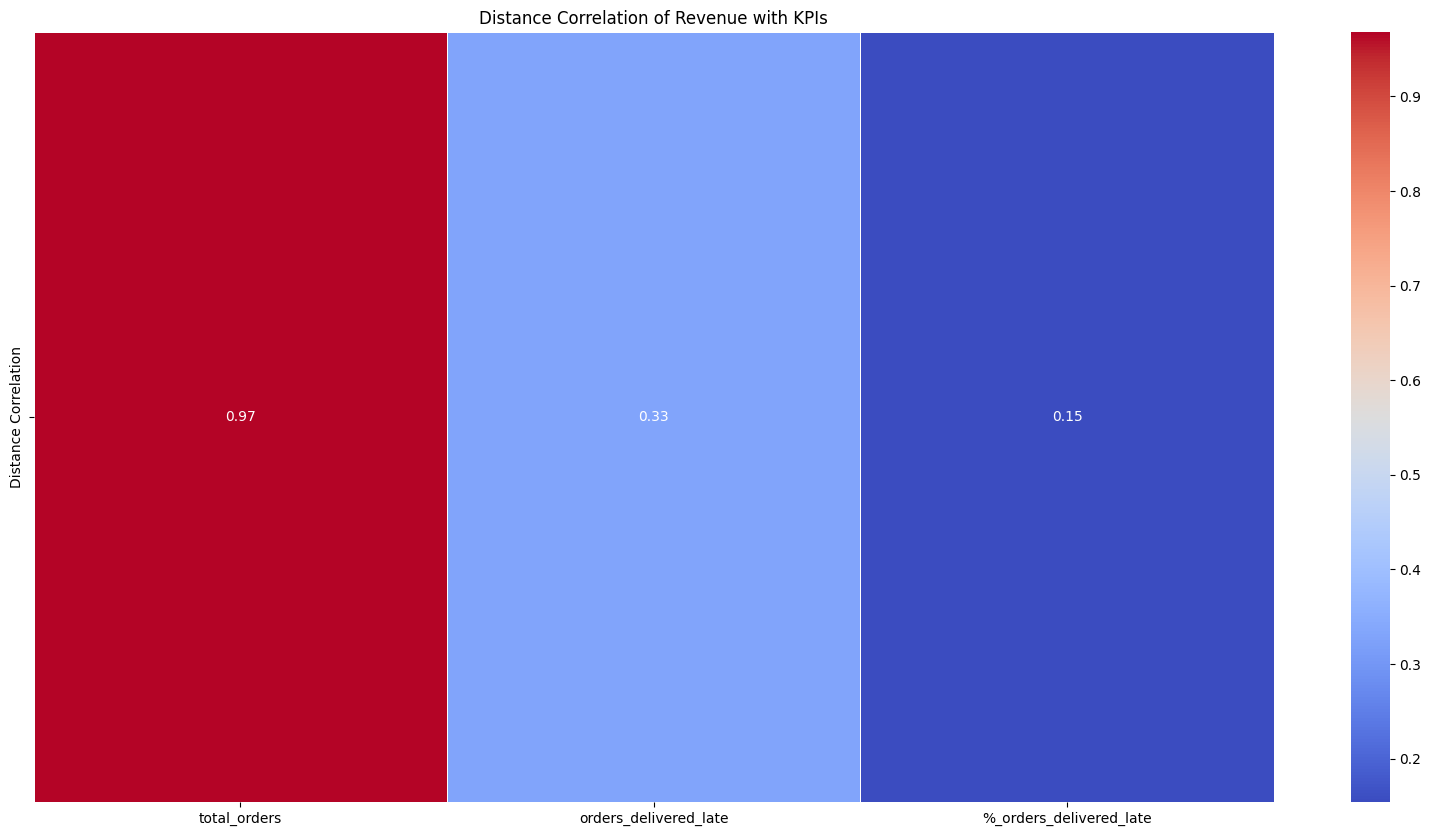

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import dcor  # Make sure you have the `dcor` package installed

# Select numeric KPI columns
numeric_kpis = monthly_kpis.select_dtypes(include=['number']).columns

# Compute distance correlations
dist_corrs = {col: dcor.distance_correlation(merged_df["revenue"], merged_df[col]) for col in numeric_kpis}

# Convert to DataFrame for visualization
dist_corr_df = pd.DataFrame.from_dict(dist_corrs, orient='index', columns=['Distance Correlation'])

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(dist_corr_df.T, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Distance Correlation of Revenue with KPIs")
plt.show()


c:\Users\ajsal\anaconda3\envs\gcenv\lib\site-packages\dcor\_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
C:\Users\ajsal\AppData\Local\Temp\ipykernel_13868\591493840.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_corr_df.index, y=dist_corr_df['Normalized Correlation'], palette="coolwarm")


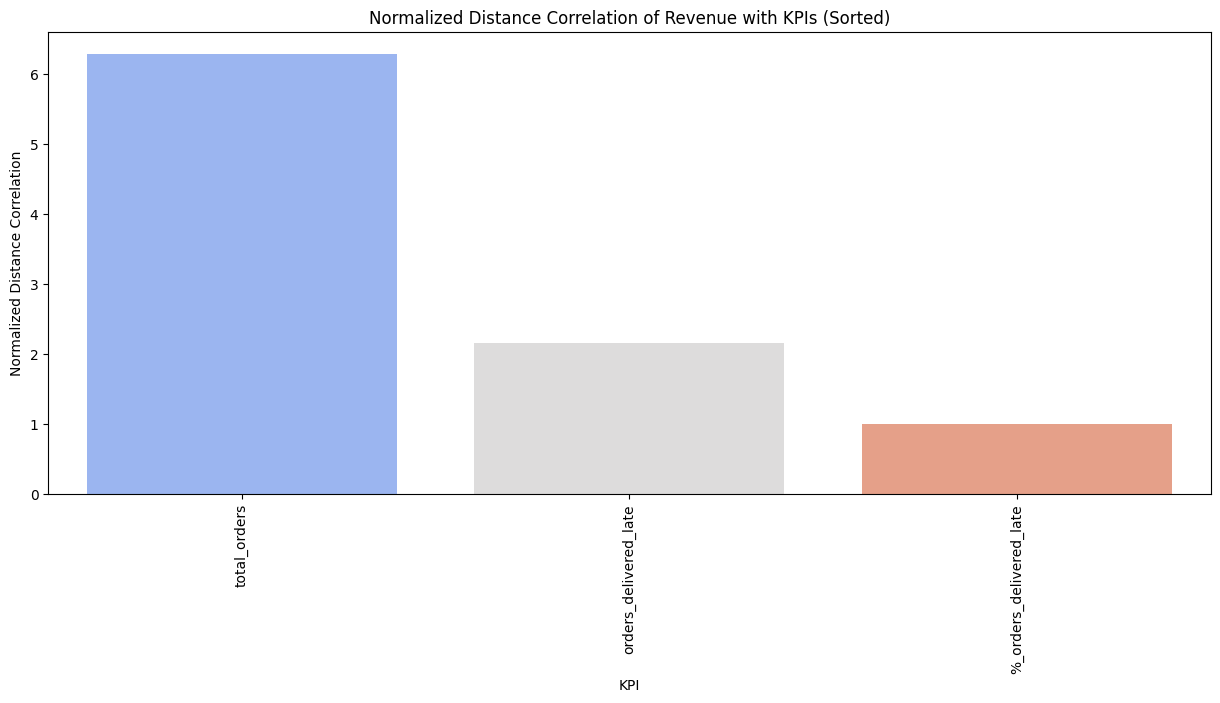

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

# Select numeric KPI columns
numeric_kpis = monthly_kpis.select_dtypes(include=['number']).columns

# Compute distance correlations
dist_corrs = {col: dcor.distance_correlation(merged_df["revenue"], merged_df[col]) for col in numeric_kpis}

# Convert to DataFrame for visualization
dist_corr_df = pd.DataFrame.from_dict(dist_corrs, orient='index', columns=['Distance Correlation'])

# Normalize by dividing by the smallest value
min_corr = dist_corr_df['Distance Correlation'].min()
dist_corr_df['Normalized Correlation'] = dist_corr_df['Distance Correlation'] / min_corr

# Sort in decreasing order
dist_corr_df = dist_corr_df.sort_values(by='Normalized Correlation', ascending=False)

# Plot bar chart
plt.figure(figsize=(15, 6))
sns.barplot(x=dist_corr_df.index, y=dist_corr_df['Normalized Correlation'], palette="coolwarm")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel("KPI")
plt.ylabel("Normalized Distance Correlation")
plt.title("Normalized Distance Correlation of Revenue with KPIs (Sorted)")
plt.show()
